# TrOCR for AWS Inferentia

**Separate encoder/decoder approach**

This notebook demonstrates how to compile the TrOCR encoder and decoder for Inferentia, and then swap the compiled models back into the original TrOCR model object.

This approach is more flexible than the alternative nn.Sequential "stacked encoder/decoder" approach, as variable sequence length can be specified at inference time. However, a possible drawback is that separate inference requests are required for each autogressive decoder call (proportional to sequence length) which could introduce latency for longer sequences.

**Reference:** https://huggingface.co/docs/transformers/en/model_doc/trocr

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.2.2.3.0.0 neuron-cc[tensorflow] \
    "protobuf<4" torch==1.10.2 torchvision==0.11.3 transformers==4.21.3 \
    sentencepiece==0.1.97 delegateto==1.5 --extra-index-url https://download.pytorch.org/whl/torch_stable.html
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

## 2) Initialize libraries and prepare input samples

In [ ]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten") 

# Maximum sequence length. Autoregressive calls into the decoder can stop before this length is achieved. 
max_length = 32  

input_ids=torch.zeros([1, max_length], dtype=torch.int64)
attention_mask=torch.zeros([1, max_length], dtype=torch.int64)
encoder_hidden_states=torch.rand([1, 578, 384])
pad_size = torch.as_tensor(0)

xenc = torch.rand(1,3,384,384).float()
xdec = (input_ids, attention_mask, encoder_hidden_states, pad_size)

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten").eval()

### 3.1) Adjust the encoder to make it traceable

In [ ]:
import types
from transformers.modeling_outputs import BaseModelOutputWithPooling
def e(self, pixel_values, **kwargs):    
    if torch.jit.is_tracing():
        print('tracing encoder...')
        return self.forward_(pixel_values, **kwargs).last_hidden_state
    elif hasattr(self, 'forward_neuron'):
        return BaseModelOutputWithPooling(self.forward_neuron(pixel_values))
    else:
        return self.forward_(pixel_values, **kwargs)

if not hasattr(model.encoder, 'forward_'): model.encoder.forward_ = model.encoder.forward
model.encoder.forward = types.MethodType(e, model.encoder)

### 3.2) Adjust the decoder to make it traceable
The decoder is more complex because it is invoked many times during prediction with different input shapes. We need to pad the input shapes before compiling the model.

In [ ]:
import types
import torch.nn.functional as F
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

def reduce(self, logits, index):
    _, n_length, _ = logits.shape

    # Create selection mask
    mask = torch.arange(n_length, dtype=torch.int32) == index
    mask = mask.view(1, -1, 1)

    # Broadcast mask
    masked = torch.multiply(logits, mask.to(torch.float32))

    # Reduce along 1st dimension    
    return torch.unsqueeze(torch.sum(masked, 1), 1)

def pad(self, input_ids, attention_mask, delta):
    pad_val = (0,delta)
    input_ids = F.pad(input_ids, pad_val, "constant", self.pad_token_id)
    attention_mask = F.pad(attention_mask, pad_val, "constant", 0)
    return input_ids,attention_mask

def unpad(self, out, delta):
    # Unpad outputs - if we didn't already mess with them
    return out[:,0:-delta,:] if out.shape[1] > 1 else out
    
def d(self, input_ids, attention_mask=None, encoder_hidden_states=None, pad_size=torch.as_tensor(0), **kwargs):
    kwargs["use_cache"] = False
    if torch.jit.is_tracing():
        print('tracing decoder...')
        decoder_out = self.model.decoder(input_ids, attention_mask, encoder_hidden_states, **kwargs)
        index = torch.as_tensor(decoder_out[0].shape[1] - 1) - pad_size        
        logits = self.output_projection( self.reduce(decoder_out[0], index) )
        return logits, decoder_out.last_hidden_state
    elif hasattr(self, 'forward_neuron'):        
        assert input_ids.shape[1] == attention_mask.shape[1]
        pad_size = torch.as_tensor(self.max_decoder_length - input_ids.shape[1])
        input_ids, attention_mask = self.pad(input_ids, attention_mask, pad_size)
        out = self.forward_neuron(input_ids, attention_mask, encoder_hidden_states, pad_size)        
        logits,last_hidden_state = [self.unpad(o, pad_size) for o in out]
        return CausalLMOutputWithCrossAttentions(logits=logits, hidden_states=last_hidden_state)
    else:        
        return self.forward_(input_ids, attention_mask, encoder_hidden_states, **kwargs)        

if not hasattr(model.decoder, 'forward_'): model.decoder.forward_ = model.decoder.forward
if not hasattr(model.decoder, 'max_decoder_length'): model.decoder.max_decoder_length = max_length
if not hasattr(model.decoder, 'pad_token_id'): model.decoder.pad_token_id = model.config.decoder.pad_token_id

model.decoder.forward = types.MethodType(d, model.decoder)
model.decoder.pad = types.MethodType(pad, model.decoder)
model.decoder.unpad = types.MethodType(unpad, model.decoder)
model.decoder.reduce = types.MethodType(reduce, model.decoder)

In [ ]:
import inspect
try:
    traced_encoder = torch.jit.trace(model.encoder, xenc)
    traced_decoder = torch.jit.trace(model.decoder, xdec)
    print(traced_encoder(xenc).shape)
    y,z=traced_decoder(*xdec)
    print(y.shape, z.shape)    
    print("Cool! Model is jit traceable")
except Exception as e:
    print(f"Ops. Something went wrong. Model is not traceable {e}")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

### 3.3) Quick test to verify the traced modules

In [ ]:
out_before = model.generate(xenc, pad_token_id=model.config.decoder.eos_token_id)
model.encoder.forward_neuron = traced_encoder
model.decoder.forward_neuron = traced_decoder
out_after = model.generate(xenc, pad_token_id=model.config.decoder.eos_token_id)
print( "all good" if (out_before == out_after).all() else "oops... error")

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model.encoder, example_inputs=xenc)
torch.neuron.analyze_model(model.decoder, example_inputs=xdec)

In [ ]:
import os
import torch
import torch.neuron

if not os.path.isfile("troc_encoder_neuron.pt"):
    model_neuron_encoder = torch.neuron.trace(model.encoder, example_inputs=xenc)
    ## Export to saved model
    model_neuron_encoder.save("troc_encoder_neuron.pt")

if not os.path.isfile("troc_decoder_neuron.pt"):
    ops = torch.neuron.get_supported_operations() + ['aten::embedding']
    model_neuron_decoder = torch.neuron.trace(
        model.decoder, example_inputs=xdec, op_whitelist=ops, compiler_args="--fast-math none")
    ## Export to saved model
    model_neuron_decoder.save("troc_decoder_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
import torch
import torch.neuron
model.encoder.forward_neuron = torch.load('troc_encoder_neuron.pt')
model.decoder.forward_neuron = torch.load('troc_decoder_neuron.pt')

generated_ids = model.generate(xenc, pad_token_id=model.config.decoder.eos_token_id)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

## 5) A simple test to check the predictions

Industrie, " Mr. Brown commented icily. " Let us have a


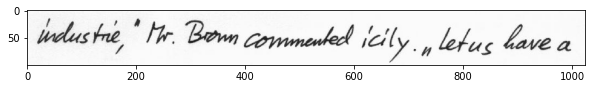

In [19]:
%matplotlib inline
import os
import sys
import cv2
import urllib
import matplotlib.pyplot as plt
if not '..' in sys.path: sys.path.append('..')

from common import processing

max_len = 32
img = processing.load_sample_imgE()

pixel_values = processor(img, max_length=max_length, padding='max_length', 
                         truncate=True, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values, pad_token_id=model.config.decoder.eos_token_id, max_length=max_len)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
plt.figure(figsize=(10,5))
plt.imshow(img)